# XGBoost 피싱 탐지 모델 (19개 URL 특수문자 피처)

이 노트북은 19개의 URL 특수문자 특징으로 XGBoost 피싱 탐지 모델을 학습합니다.

## 목표
- Dataset1과 Dataset2를 통합하여 XGBoost 모델 학습 (3가지 시나리오)
- 특징 중요도 분석 및 비교
- 모델 성능 평가 (Accuracy, Precision, Recall, F1, AUC)

## 프레임워크
1. 모델 초기화 및 환경 설정
2. 데이터 로드 및 전처리
3. XGBoost 모델 학습 (3가지 시나리오)
4. 모델 평가 및 시각화
5. 결과 저장

===== 0) 모델 초기화 (Linux 환경) =====

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 59.6 MB/s  0:00:01 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import sys

print(f"Python 버전: {sys.version}")
print(f"작업 디렉토리: {os.getcwd()}")
print("\n✅ 환경 초기화 완료")

Python 버전: 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
작업 디렉토리: /home/wza/QR_Phishing/phishing

✅ 환경 초기화 완료


===== 1) 환경 설정 및 Import =====

In [4]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from xgboost import XGBClassifier

print(f"NumPy 버전: {np.__version__}")
print(f"Pandas 버전: {pd.__version__}")
print(f"XGBoost 버전: {__import__('xgboost').__version__}")
print(f"Matplotlib 버전: {__import__('matplotlib').__version__}")
print(f"Seaborn 버전: {__import__('seaborn').__version__}")
print("\n✅ 모든 라이브러리 Import 완료")

NumPy 버전: 1.26.4
Pandas 버전: 2.3.3
XGBoost 버전: 3.1.2
Matplotlib 버전: 3.10.7
Seaborn 버전: 0.13.2

✅ 모든 라이브러리 Import 완료


===== 2) 설정 =====

In [5]:
# 🔧 Linux 환경 경로
DATASET_DIR = '/home/wza/QR_Phishing/phishing/Deviation-in-Feature-Contribution-7760/Dataset'

# 학습 데이터
DATA1_TRAIN = os.path.join(DATASET_DIR, 'original_training_dataset1_70_30.csv')
DATA2_TRAIN = os.path.join(DATASET_DIR, 'Training/Dataset2/70_30_train.csv')

# 테스트 데이터
DATA1_TEST = os.path.join(DATASET_DIR, 'Testing/Dataset1/70_30_test.csv')
DATA2_TEST = os.path.join(DATASET_DIR, 'Testing/Dataset2/70_30_test.csv')

# 모델 설정
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# XGBoost 하이퍼파라미터
XGB_PARAMS = {
    'max_depth': 5,
    'objective': 'binary:logistic',
    'n_estimators': 100,
    'random_state': RANDOM_SEED,
    'eval_metric': 'logloss',
    'verbosity': 0
}

# 19개 피처 (url_google_index 제외)
FEATURE_NAMES = [
    'qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url',
    'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
    'qty_tilde_url', 'qty_comma_url', 'qty_asterisk_url', 'qty_percent_url',
    'qty_dollar_url', 'tld_present_params', 'qty_redirects', 'length_url',
    'url_shortened', 'domain_length', 'domain_in_ip'
]

# Dataset2 컬럼 매핑
DATASET2_COLS = {
    'total_of.': 'qty_dot_url',
    'total_of-': 'qty_hyphen_url',
    'total_of_': 'qty_underline_url',
    'total_of/': 'qty_slash_url',
    'total_of?': 'qty_questionmark_url',
    'total_of=': 'qty_equal_url',
    'total_of@': 'qty_at_url',
    'total_of&': 'qty_and_url',
    'total_of~': 'qty_tilde_url',
    'total_of,': 'qty_comma_url',
    'total_of*': 'qty_asterisk_url',
    'total_of%': 'qty_percent_url',
    'total_of$': 'qty_dollar_url',
    'tld_in_path': 'tld_present_params',
    'nb_redirection': 'qty_redirects',
    'url_length': 'length_url',
    'shortening_service': 'url_shortened',
    'hostname_length': 'domain_length',
    'ip': 'domain_in_ip',
    'status': 'phishing'
}

print("\n" + "="*80)
print("🔧 설정")
print("="*80)
print(f"Random Seed: {RANDOM_SEED}")
print(f"피처 개수: {len(FEATURE_NAMES)}")
print(f"XGBoost max_depth: {XGB_PARAMS['max_depth']}, n_estimators: {XGB_PARAMS['n_estimators']}")


🔧 설정
Random Seed: 42
피처 개수: 19
XGBoost max_depth: 5, n_estimators: 100


===== 3) 유틸리티 함수 =====

In [6]:
def load_data(file_path):
    """CSV 데이터 로드"""
    return pd.read_csv(file_path, encoding='utf-8', engine='python')

def select_features(df, feature_cols, target_col='phishing'):
    """피처와 타겟 선택"""
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    return X, y

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    """모델 학습 및 평가"""
    print(f"\n{'='*80}")
    print(f"📊 {model_name}")
    print(f"{'='*80}")
    
    # 학습
    print(f"▶️ 학습 중...")
    model.fit(X_train, y_train, verbose=0)
    print(f"✅ 학습 완료")
    
    # 예측
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 메트릭 계산
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n📈 성능 메트릭:")
    print(f"   - Accuracy:  {accuracy:.4f}")
    print(f"   - Precision: {precision:.4f}")
    print(f"   - Recall:    {recall:.4f}")
    print(f"   - F1 Score:  {f1:.4f}")
    print(f"   - AUC:       {auc:.4f}")
    
    print(f"\n📋 분류 리포트:")
    print(classification_report(y_test, y_pred, target_names=['정상(0)', '피싱(1)']))
    
    return {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

print("\n✅ 유틸리티 함수 정의 완료")


✅ 유틸리티 함수 정의 완료


===== 4) 데이터 로드 =====

In [7]:
print("\n" + "="*80)
print("📂 데이터 로드 중...")
print("="*80)

# 학습 데이터 로드
df1_train = load_data(DATA1_TRAIN)
df2_train = load_data(DATA2_TRAIN)

print(f"\n✅ 학습 데이터 로드 완료:")
print(f"   - Dataset1 Train: {df1_train.shape}")
print(f"   - Dataset2 Train: {df2_train.shape}")
print(f"   - 클래스 분포 (D1): {df1_train['phishing'].value_counts().to_dict()}")
print(f"   - 클래스 분포 (D2): {df2_train['status'].value_counts().to_dict()}")

# 테스트 데이터 로드
df1_test = load_data(DATA1_TEST)
df2_test = load_data(DATA2_TEST)

print(f"\n✅ 테스트 데이터 로드 완료:")
print(f"   - Dataset1 Test: {df1_test.shape}")
print(f"   - Dataset2 Test: {df2_test.shape}")


📂 데이터 로드 중...

✅ 학습 데이터 로드 완료:
   - Dataset1 Train: (67222, 99)
   - Dataset2 Train: (13601, 80)
   - 클래스 분포 (D1): {0: 40614, 1: 26608}
   - 클래스 분포 (D2): {0: 6831, 1: 6770}

✅ 테스트 데이터 로드 완료:
   - Dataset1 Test: (26595, 99)
   - Dataset2 Test: (5830, 80)


===== 5) 데이터 전처리 (19개 피처만 선택) =====

In [8]:
print("\n" + "="*80)
print("🔄 학습 데이터 전처리")
print("="*80)

# Dataset1에서 19개 피처 선택
X1_train, y1_train = select_features(df1_train, FEATURE_NAMES, 'phishing')

print(f"\n✅ Dataset1 학습 데이터:")
print(f"   - X shape: {X1_train.shape}")
print(f"   - y shape: {y1_train.shape}")
print(f"   - 클래스 분포: {y1_train.value_counts().to_dict()}")

# Dataset2 컬럼 이름 변경
df2_train_renamed = df2_train.rename(columns=DATASET2_COLS)
X2_train, y2_train = select_features(df2_train_renamed, FEATURE_NAMES, 'phishing')

print(f"\n✅ Dataset2 학습 데이터:")
print(f"   - X shape: {X2_train.shape}")
print(f"   - y shape: {y2_train.shape}")
print(f"   - 클래스 분포: {y2_train.value_counts().to_dict()}")


🔄 학습 데이터 전처리

✅ Dataset1 학습 데이터:
   - X shape: (67222, 19)
   - y shape: (67222,)
   - 클래스 분포: {0: 40614, 1: 26608}

✅ Dataset2 학습 데이터:
   - X shape: (13601, 19)
   - y shape: (13601,)
   - 클래스 분포: {0: 6831, 1: 6770}


In [9]:
# Dataset1 균형 맞추기 (6800 샘플씩)
phish_mask = y1_train == 1
legit_mask = y1_train == 0

X1_phish = X1_train[phish_mask].sample(n=6800, random_state=RANDOM_SEED)
y1_phish = y1_train[phish_mask].sample(n=6800, random_state=RANDOM_SEED)

X1_legit = X1_train[legit_mask].sample(n=6800, random_state=RANDOM_SEED)
y1_legit = y1_train[legit_mask].sample(n=6800, random_state=RANDOM_SEED)

print(f"\n✅ Dataset1 균형 조정:")
print(f"   - 피싱(1): {len(X1_phish)}개")
print(f"   - 정상(0): {len(X1_legit)}개")


✅ Dataset1 균형 조정:
   - 피싱(1): 6800개
   - 정상(0): 6800개


In [10]:
# 데이터 통합 (균형잡힌 D1 + D2)
X_merged_train = pd.concat([X1_phish, X1_legit, X2_train], ignore_index=True)
y_merged_train = pd.concat([y1_phish, y1_legit, y2_train], ignore_index=True)

# 셔플
indices = np.arange(len(X_merged_train))
np.random.shuffle(indices)

X_merged_train = X_merged_train.iloc[indices].reset_index(drop=True)
y_merged_train = y_merged_train.iloc[indices].reset_index(drop=True)

print(f"\n✅ 통합 학습 데이터:")
print(f"   - X shape: {X_merged_train.shape}")
print(f"   - y shape: {y_merged_train.shape}")
print(f"   - 클래스 분포: {y_merged_train.value_counts().to_dict()}")
print(f"   - 피싱 비율: {y_merged_train.mean()*100:.2f}%")


✅ 통합 학습 데이터:
   - X shape: (27201, 19)
   - y shape: (27201,)
   - 클래스 분포: {0: 13631, 1: 13570}
   - 피싱 비율: 49.89%


===== 6) 테스트 데이터 전처리 =====

In [11]:
print("\n" + "="*80)
print("🔄 테스트 데이터 전처리")
print("="*80)

# Dataset1 테스트
X1_test, y1_test = select_features(df1_test, FEATURE_NAMES, 'phishing')

# Dataset2 테스트
df2_test_renamed = df2_test.rename(columns=DATASET2_COLS)
X2_test, y2_test = select_features(df2_test_renamed, FEATURE_NAMES, 'phishing')

# 통합 테스트
X_merged_test = pd.concat([X1_test, X2_test], ignore_index=True)
y_merged_test = pd.concat([y1_test, y2_test], ignore_index=True)

# 셔플
indices = np.arange(len(X_merged_test))
np.random.shuffle(indices)

X_merged_test = X_merged_test.iloc[indices].reset_index(drop=True)
y_merged_test = y_merged_test.iloc[indices].reset_index(drop=True)

print(f"\n✅ Dataset1 테스트: {X1_test.shape}")
print(f"   - 클래스 분포: {y1_test.value_counts().to_dict()}")
print(f"\n✅ Dataset2 테스트: {X2_test.shape}")
print(f"   - 클래스 분포: {y2_test.value_counts().to_dict()}")
print(f"\n✅ 통합 테스트: {X_merged_test.shape}")
print(f"   - 클래스 분포: {y_merged_test.value_counts().to_dict()}")


🔄 테스트 데이터 전처리

✅ Dataset1 테스트: (26595, 19)
   - 클래스 분포: {0: 17386, 1: 9209}

✅ Dataset2 테스트: (5830, 19)
   - 클래스 분포: {1: 2945, 0: 2885}

✅ 통합 테스트: (32425, 19)
   - 클래스 분포: {0: 20271, 1: 12154}


===== 7) XGBoost 모델 학습 (3가지 시나리오) =====

In [12]:
# 시나리오 1: 통합 학습 → 통합 테스트
xgb_model_1 = XGBClassifier(**XGB_PARAMS)
results_1 = train_and_evaluate(
    xgb_model_1, X_merged_train, y_merged_train, 
    X_merged_test, y_merged_test, 
    "Scenario 1: Merged Train → Merged Test"
)


📊 Scenario 1: Merged Train → Merged Test
▶️ 학습 중...
✅ 학습 완료

📈 성능 메트릭:
   - Accuracy:  0.8955
   - Precision: 0.8337
   - Recall:    0.9009
   - F1 Score:  0.8660
   - AUC:       0.9639

📋 분류 리포트:
              precision    recall  f1-score   support

       정상(0)       0.94      0.89      0.91     20271
       피싱(1)       0.83      0.90      0.87     12154

    accuracy                           0.90     32425
   macro avg       0.89      0.90      0.89     32425
weighted avg       0.90      0.90      0.90     32425



In [13]:
# 시나리오 2: 통합 학습 → Dataset1 테스트
xgb_model_2 = XGBClassifier(**XGB_PARAMS)
results_2 = train_and_evaluate(
    xgb_model_2, X_merged_train, y_merged_train, 
    X1_test, y1_test, 
    "Scenario 2: Merged Train → Dataset1 Test"
)


📊 Scenario 2: Merged Train → Dataset1 Test
▶️ 학습 중...
✅ 학습 완료

📈 성능 메트릭:
   - Accuracy:  0.9102
   - Precision: 0.8293
   - Recall:    0.9328
   - F1 Score:  0.8780
   - AUC:       0.9726

📋 분류 리포트:
              precision    recall  f1-score   support

       정상(0)       0.96      0.90      0.93     17386
       피싱(1)       0.83      0.93      0.88      9209

    accuracy                           0.91     26595
   macro avg       0.90      0.92      0.90     26595
weighted avg       0.92      0.91      0.91     26595



In [14]:
# 시나리오 3: 통합 학습 → Dataset2 테스트
xgb_model_3 = XGBClassifier(**XGB_PARAMS)
results_3 = train_and_evaluate(
    xgb_model_3, X_merged_train, y_merged_train, 
    X2_test, y2_test, 
    "Scenario 3: Merged Train → Dataset2 Test"
)


📊 Scenario 3: Merged Train → Dataset2 Test
▶️ 학습 중...
✅ 학습 완료

📈 성능 메트릭:
   - Accuracy:  0.8281
   - Precision: 0.8498
   - Recall:    0.8014
   - F1 Score:  0.8249
   - AUC:       0.9106

📋 분류 리포트:
              precision    recall  f1-score   support

       정상(0)       0.81      0.86      0.83      2885
       피싱(1)       0.85      0.80      0.82      2945

    accuracy                           0.83      5830
   macro avg       0.83      0.83      0.83      5830
weighted avg       0.83      0.83      0.83      5830



===== 8) 모델 성능 비교 =====

In [15]:
# 비교 테이블
comparison_data = {
    'Scenario': ['Merged→Merged', 'Merged→D1', 'Merged→D2'],
    'Accuracy': [results_1['accuracy'], results_2['accuracy'], results_3['accuracy']],
    'Precision': [results_1['precision'], results_2['precision'], results_3['precision']],
    'Recall': [results_1['recall'], results_2['recall'], results_3['recall']],
    'F1 Score': [results_1['f1'], results_2['f1'], results_3['f1']],
    'AUC': [results_1['auc'], results_2['auc'], results_3['auc']]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("📊 모델 성능 비교 (19개 피처 XGBoost)")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


📊 모델 성능 비교 (19개 피처 XGBoost)
     Scenario  Accuracy  Precision   Recall  F1 Score      AUC
Merged→Merged  0.895482   0.833651 0.900938  0.865989 0.963887
    Merged→D1  0.910246   0.829311 0.932783  0.878009 0.972594
    Merged→D2  0.828130   0.849838 0.801358  0.824886 0.910590


===== 9) 시각화 - 성능 메트릭 비교 =====

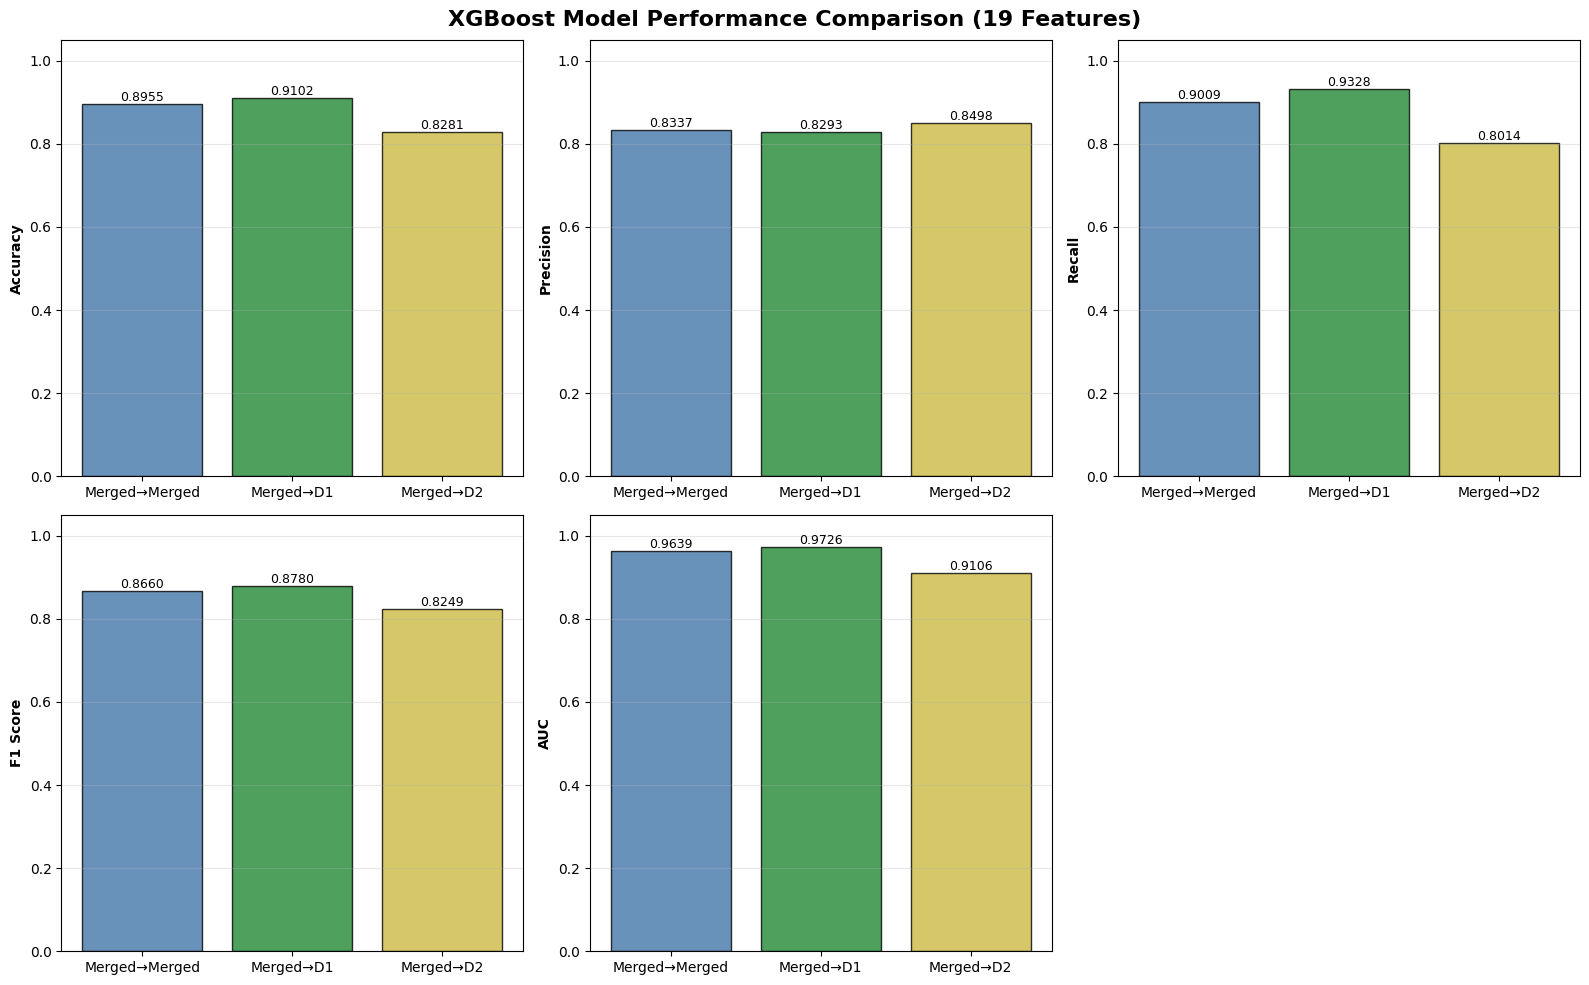

✅ Performance metric visualization complete


In [16]:
# 성능 메트릭 시각화
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('XGBoost Model Performance Comparison (19 Features)', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
scenarios = ['Merged→Merged', 'Merged→D1', 'Merged→D2']

results = [
    [results_1['accuracy'], results_1['precision'], results_1['recall'], results_1['f1'], results_1['auc']],
    [results_2['accuracy'], results_2['precision'], results_2['recall'], results_2['f1'], results_2['auc']],
    [results_3['accuracy'], results_3['precision'], results_3['recall'], results_3['f1'], results_3['auc']]
]

colors = ['#4477AA', '#228833', '#CCBB44']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    values = [results[i][idx] for i in range(3)]
    bars = ax.bar(scenarios, values, color=colors, alpha=0.8, edgecolor='black')
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=9)

axes[1, 2].remove()

plt.tight_layout()
plt.show()

print("✅ Performance metric visualization complete")

===== 10) 시각화 - ROC 곡선 =====

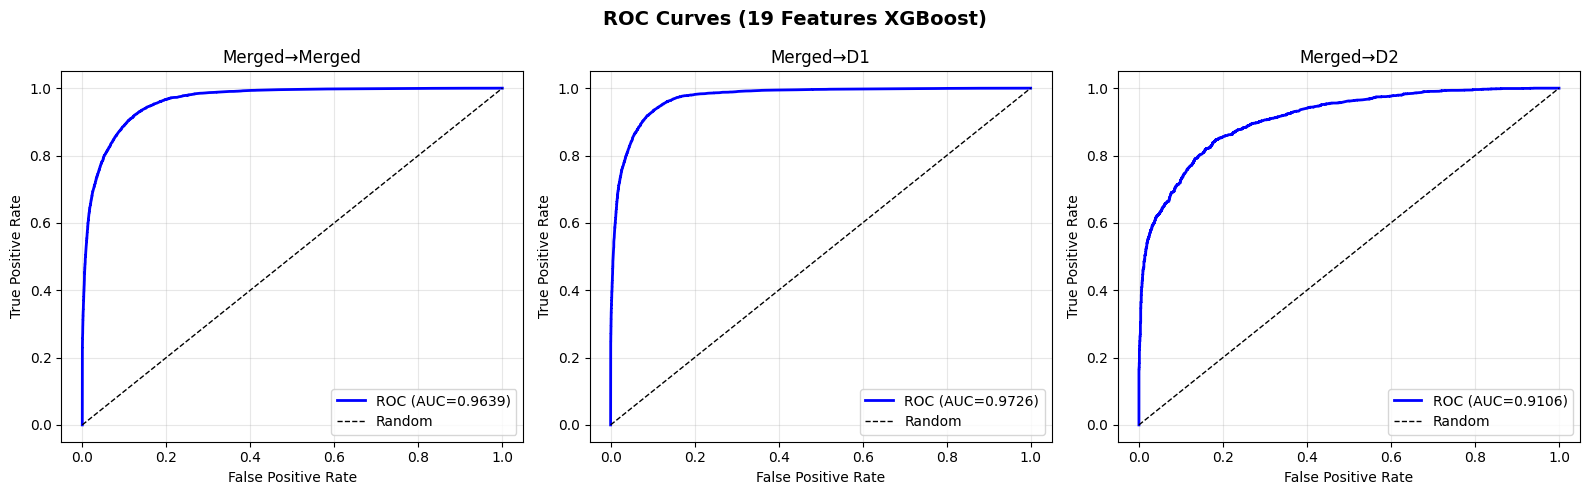

✅ ROC curve visualization complete


In [17]:
# ROC 곡선
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('ROC Curves (19 Features XGBoost)', fontsize=14, fontweight='bold')

test_data = [
    (y_merged_test, results_1['y_pred_proba'], 'Merged→Merged', axes[0]),
    (y1_test, results_2['y_pred_proba'], 'Merged→D1', axes[1]),
    (y2_test, results_3['y_pred_proba'], 'Merged→D2', axes[2])
]

for y_true, y_proba, title, ax in test_data:
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    
    ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC={auc:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ ROC curve visualization complete")

===== 11) 시각화 - Confusion Matrix =====

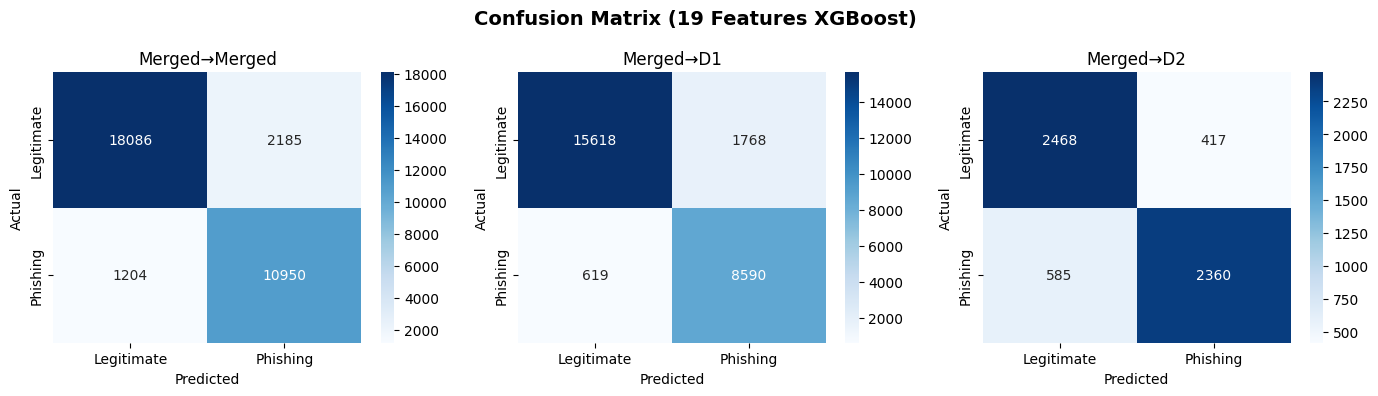

✅ Confusion matrix visualization complete


In [18]:
# Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Confusion Matrix (19 Features XGBoost)', fontsize=14, fontweight='bold')

cms_data = [
    (results_1['y_pred'], y_merged_test, 'Merged→Merged', axes[0]),
    (results_2['y_pred'], y1_test, 'Merged→D1', axes[1]),
    (results_3['y_pred'], y2_test, 'Merged→D2', axes[2])
]

for y_pred, y_true, title, ax in cms_data:
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(title)

plt.tight_layout()
plt.show()

print("✅ Confusion matrix visualization complete")

===== 12) 특징 중요도 분석 =====

In [19]:
# 모든 모델의 특징 중요도 추출
importance_df = pd.DataFrame({
    'Feature': FEATURE_NAMES,
    'Model1_Importance': results_1['model'].feature_importances_,
    'Model2_Importance': results_2['model'].feature_importances_,
    'Model3_Importance': results_3['model'].feature_importances_
}).sort_values('Model1_Importance', ascending=False)

# 평균 중요도 계산
importance_df['Mean_Importance'] = importance_df[['Model1_Importance', 'Model2_Importance', 'Model3_Importance']].mean(axis=1)

print("\n" + "="*120)
print("📊 Feature Importance Analysis (XGBoost - 19 Features)")
print("="*120)
print(importance_df.to_string(index=False))
print("="*120)


📊 Feature Importance Analysis (XGBoost - 19 Features)
             Feature  Model1_Importance  Model2_Importance  Model3_Importance  Mean_Importance
       qty_slash_url           0.261976           0.261976           0.261976         0.261976
  tld_present_params           0.171309           0.171309           0.171309         0.171309
       qty_equal_url           0.128788           0.128788           0.128788         0.128788
          qty_at_url           0.072203           0.072203           0.072203         0.072203
         qty_dot_url           0.052380           0.052380           0.052380         0.052380
      qty_hyphen_url           0.049078           0.049078           0.049078         0.049078
       url_shortened           0.041490           0.041490           0.041490         0.041490
   qty_underline_url           0.039547           0.039547           0.039547         0.039547
          length_url           0.037929           0.037929           0.037929         0.03

===== 13) 시각화 - 특징 중요도 =====

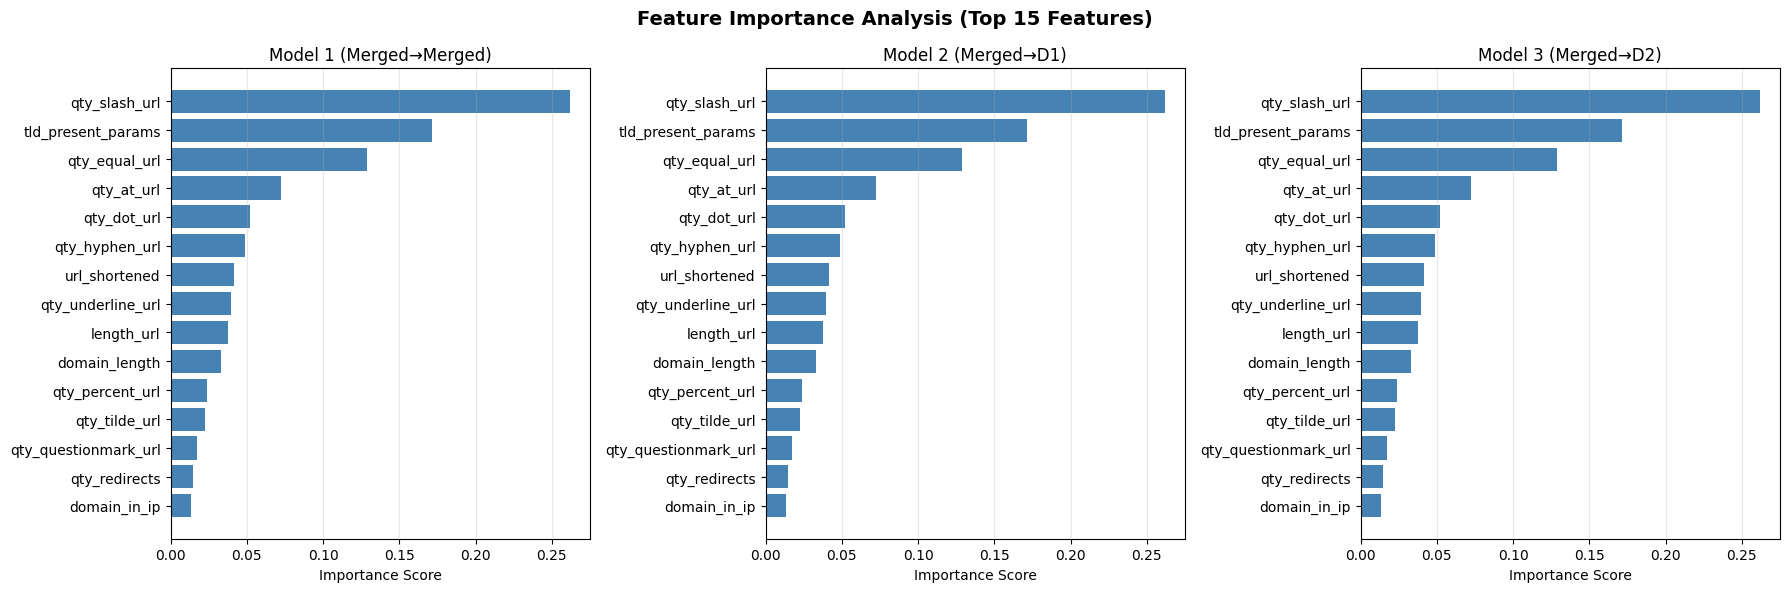

✅ Feature importance visualization complete


In [20]:
# 특징 중요도 시각화 (상위 15개)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Feature Importance Analysis (Top 15 Features)', fontsize=14, fontweight='bold')

for idx, (ax, model_col) in enumerate(zip(axes, ['Model1_Importance', 'Model2_Importance', 'Model3_Importance'])):
    top_features = importance_df.nlargest(15, model_col)
    ax.barh(range(len(top_features)), top_features[model_col], color='steelblue')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Importance Score')
    model_names = ['Model 1 (Merged→Merged)', 'Model 2 (Merged→D1)', 'Model 3 (Merged→D2)']
    ax.set_title(model_names[idx])
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Feature importance visualization complete")

===== 14) 결과 저장 =====

In [ ]:
# 결과 저장
output_dir = '/home/wza/QR_Phishing/phishing/Deviation-in-Feature-Contribution-7760/Code'

# 성능 메트릭 저장
comparison_df.to_csv(f'{output_dir}/xgboost_19features_performance.csv', index=False)

# 특징 중요도 저장
importance_df.to_csv(f'{output_dir}/xgboost_19features_importance.csv', index=False)

print("\n" + "="*80)
print("✅ Results saved successfully")
print("="*80)
print(f"\n📁 Output files:")
print(f"   - {output_dir}/xgboost_19features_performance.csv")
print(f"   - {output_dir}/xgboost_19features_importance.csv")

===== 15) 최종 요약 =====

In [ ]:
print("\n" + "="*80)
print("📋 Final Summary")
print("="*80)

print(f"\n✅ Dataset Information:")
print(f"   Train: {X_merged_train.shape[0]:,} samples (Phishing: {(y_merged_train==1).sum():,}, Legitimate: {(y_merged_train==0).sum():,})")
print(f"   Test (Merged): {X_merged_test.shape[0]:,} samples")
print(f"   Test (D1): {X1_test.shape[0]:,} samples")
print(f"   Test (D2): {X2_test.shape[0]:,} samples")

print(f"\n✅ Model Configuration:")
print(f"   Framework: XGBoost")
print(f"   Features: {len(FEATURE_NAMES)} (URL structural features)")
print(f"   Hyperparameters: max_depth={XGB_PARAMS['max_depth']}, n_estimators={XGB_PARAMS['n_estimators']}")

print(f"\n✅ Model Performance:")
print(f"   Model 1 (Merged→Merged):   Accuracy={results_1['accuracy']:.4f}, AUC={results_1['auc']:.4f}")
print(f"   Model 2 (Merged→D1):       Accuracy={results_2['accuracy']:.4f}, AUC={results_2['auc']:.4f}")
print(f"   Model 3 (Merged→D2):       Accuracy={results_3['accuracy']:.4f}, AUC={results_3['auc']:.4f}")

print(f"\n✅ Top 5 Important Features (Model 1):")
for idx, row in importance_df.head(5).iterrows():
    print(f"   {row['Feature']:<25} : {row['Model1_Importance']:.6f}")

print(f"\n✅ Output Files:")
print(f"   - xgboost_19features_performance.csv")
print(f"   - xgboost_19features_importance.csv")

print("\n" + "="*80)
print("🎉 Analysis Complete!")
print("="*80)